### <u> Importing Libraries & Data

In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import shutil
import random

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

cuda


In [3]:
#Transform the input images
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
#Create a dataloader

#Directory path for the training & test images
train_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/train'
test_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=16, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
) 


In [5]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)


['NORMAL', 'PNEUMONIA']


### <u> Step 1: Using a pre-trained neural network from PyTorch

In [6]:
#Loading pre-trained ResNet18 model
resnet = torchvision.models.resnet18(pretrained=True)

/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#Freezing all layers except the last one
for param in resnet.parameters():
    param.requires_grad=False
    

In [8]:
#Replace the last layer with our own classifier
num_ftrs=resnet.fc.in_features
resnet.fc=nn.Linear(num_ftrs, 2)

#Move the model to the device
model=resnet.to(device)

In [9]:
#Input the optimizer & loss function
optimizer=Adam(model.parameters(), lr=0.003, weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
# loss_function=nn.BCEWithLogitsLoss()

In [10]:
num_epochs=20

In [11]:
# calculating the size of training and testing images
train_count = len(glob.glob(train_path + '/**/*.jpeg'))
test_count = len(glob.glob(test_path + '/**/*.jpeg'))

print(train_count)
print(test_count)

train_acc_list = []
test_acc_list = []
loss_list = []

5216
624


In [13]:
train_acc_list = []
test_acc_list = []
loss_list = []

In [14]:
# Model training and saving best model

best_accuracy = 0.0

for epoch in range(num_epochs):

    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    loss_list.append(train_loss)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy


Epoch: 0 Train Loss: tensor(0.2220) Train Accuracy: 0.9139187116564417 Test Accuracy: 0.8509615384615384
Epoch: 1 Train Loss: tensor(0.2206) Train Accuracy: 0.9175613496932515 Test Accuracy: 0.8733974358974359
Epoch: 2 Train Loss: tensor(0.1879) Train Accuracy: 0.9300230061349694 Test Accuracy: 0.7548076923076923
Epoch: 3 Train Loss: tensor(0.1868) Train Accuracy: 0.9323236196319018 Test Accuracy: 0.8557692307692307
Epoch: 4 Train Loss: tensor(0.1756) Train Accuracy: 0.9359662576687117 Test Accuracy: 0.7868589743589743
Epoch: 5 Train Loss: tensor(0.1994) Train Accuracy: 0.9244631901840491 Test Accuracy: 0.8028846153846154
Epoch: 6 Train Loss: tensor(0.1936) Train Accuracy: 0.932898773006135 Test Accuracy: 0.8237179487179487
Epoch: 7 Train Loss: tensor(0.1724) Train Accuracy: 0.9386503067484663 Test Accuracy: 0.8060897435897436
Epoch: 8 Train Loss: tensor(0.1818) Train Accuracy: 0.9355828220858896 Test Accuracy: 0.8733974358974359
Epoch: 9 Train Loss: tensor(0.1667) Train Accuracy: 0.93

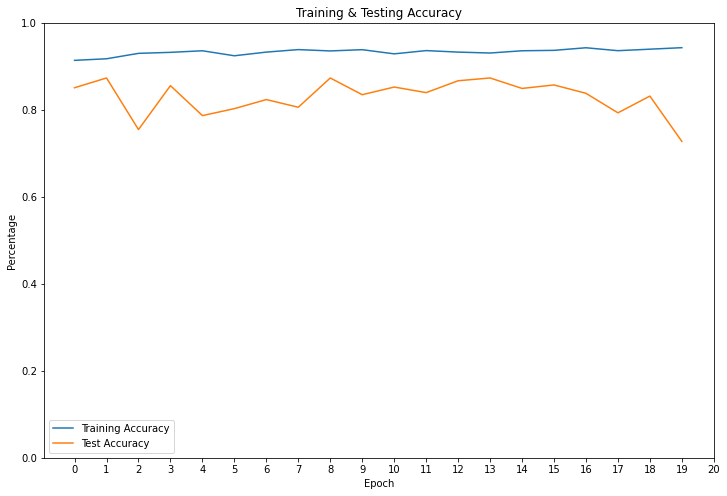

In [15]:
# Plot the results
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,8))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xticks(range(21))
plt.ylim(0,1)
plt.show()